## 16.1 Tutorial Overview
This tutorial is divided into five parts; they are:
1. Power Consumption Dataset
2. Load Dataset
3. Patterns in Observations Over Time 4. Time Series Data Distributions
5. Ideas on Modeling

## 16.2 Household Power Consumption Dataset

The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute. It is a multivariate series comprised of seven variables
(besides the date and time); they are:
- global_active_power: The total active power consumed by the household (kilowatts).
- global_reactive_power: The total reactive power consumed by the household (kilowatts). 􏰀 
- voltage: Average voltage (volts).
- global_intensity: Average current intensity (amps).
- sub_metering 1: Active energy for kitchen (watt-hours of active energy).
- sub_metering 2: Active energy for laundry (watt-hours of active energy).
- sub_metering 3: Active energy for climate control systems (watt-hours of active energy).

We can see that the dataset provides the active power as well as some division of the active power by main circuit in the house, specifically the kitchen, laundry, and climate control. These are not all the circuits in the household. The remaining watt-hours can be calculated from the active energy by first converting the active energy to watt-hours then subtracting the other sub-metered active energy in watt-hours, as follows:

\begin{equation}
reminder=(\frac{global\_act\_pwr\times1000}{60})-(sub\_met\_1+sub\_met\_2+sub\_met\_3)
\end{equation}

## 16.3 Load Dataset

We can use the read csv() function to load the data. It is easy to load the data with this function, but a little tricky to load it correctly. Specifically, we need to do a few custom things:
- Specify the separate between columns as a semicolon (sep=‘;’)
- Specify that line 0 has the names for the columns (header=0)
- Specify that we have lots of RAM to avoid a warning that we are loading the data as an array of objects instead of an array of numbers, because of the ‘?’ values for missing data (low memory=False).
- Specify that it is okay for Pandas to try to infer the date-time format when parsing dates, which is way faster (infer datetime format=True)
- Specify that we would like to parse the date and time columns together as a new column called ’datetime’ (parse dates=‘datetime’:[0,1])
- Specify that we would like our new datetime column to be the index for the DataFrame (index col=[’datetime’]).

In [3]:
# load and clean-up power usage data
from numpy import nan
from pandas import read_csv
# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# summarize
print(dataset.shape)
print(dataset.head())
# mark all missing values
dataset.replace('?', nan, inplace=True)
# add a column for for the remainder of sub metering
values = dataset.values.astype('float32')
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
print(dataset.head())

(2075259, 7)
                    Global_active_power Global_reactive_power  Voltage  \
datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.

## 16.4 Patterns in Observations Over Time

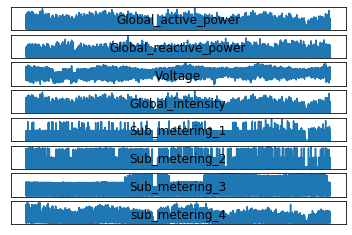

In [5]:
# line plots for power usage dataset
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# line plot for each variable
pyplot.figure()
for i in range(len(dataset.columns)):
	# create subplot
	pyplot.subplot(len(dataset.columns), 1, i+1)
	# get variable name
	name = dataset.columns[i]
	# plot data
	pyplot.plot(dataset[name])
	# set title
	pyplot.title(name, y=0)
	# turn off ticks to remove clutter
	pyplot.yticks([])
	pyplot.xticks([])
pyplot.show()

We can see that something interesting was going on in __Sub metering 3__ (environmental control) that may not directly map to hot or cold years. Perhaps new systems were installed.
Interestingly, the contribution of __sub metering 4__ seems to decrease with time, or show a downward trend, perhaps matching up with the solid increase in seen towards the end of the series for __Sub metering 3__. These observations do reinforce the need to honor __the temporal ordering__ of subsequences of this data when fitting and evaluating any model. We might be able to see the wave of a seasonal effect in the __Global active power__ and some other variates. There is some spiky usage that may match up with a specific period, such as weekends.

Let’s zoom in and focus on the Global active power, or active power for short. We can create a new plot of the active power for each year to see if there are any common patterns across the years. 

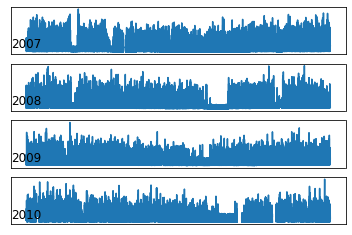

In [6]:
# yearly line plots for power usage dataset
from pandas import read_csv
from matplotlib import pyplot
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# plot active power for each year
years = ['2007', '2008', '2009', '2010']
pyplot.figure()
for i in range(len(years)):
	# prepare subplot
	ax = pyplot.subplot(len(years), 1, i+1)
	# determine the year to plot
	year = years[i]
	# get all observations for the year
	result = dataset[str(year)]
	# plot the active power for the year
	pyplot.plot(result['Global_active_power'])
	# add a title to the subplot
	pyplot.title(str(year), y=0, loc='left')
	# turn off ticks to remove clutter
	pyplot.yticks([])
	pyplot.xticks([])
pyplot.show()

We can continue to zoom in on consumption and look at active power for each of the 12 months of 2007. This might help tease out gross structures across the months, such as daily and weekly patterns. 

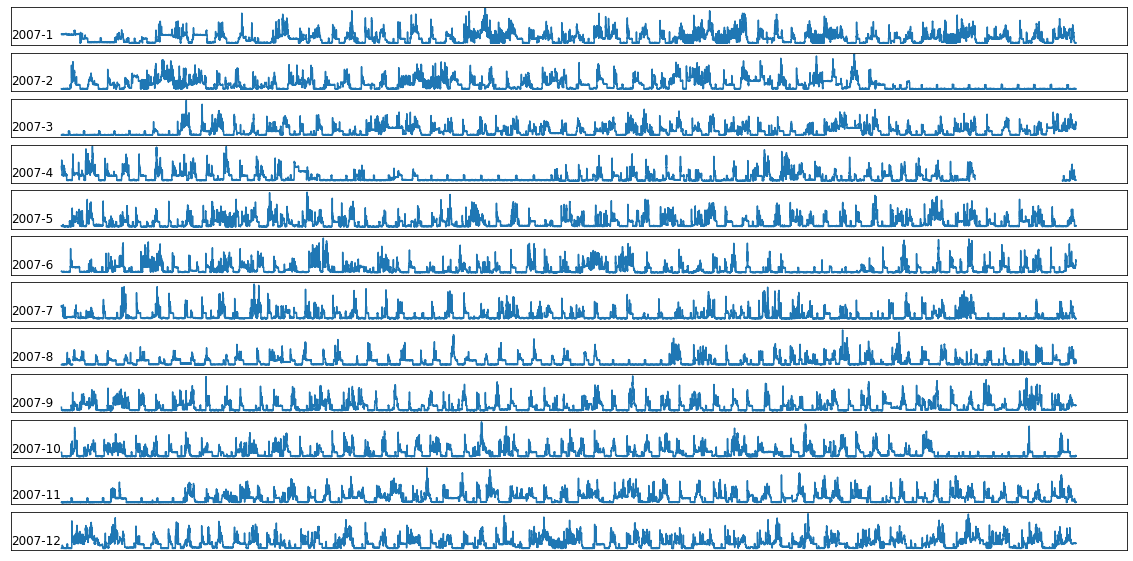

In [21]:
# monthly line plots for power usage dataset
from pandas import read_csv
from matplotlib import pyplot
pyplot.rcParams["figure.figsize"] = (20,10)
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# plot active power for each year
months = [x for x in range(1, 13)]
pyplot.figure()
for i in range(len(months)):
	# prepare subplot
	ax = pyplot.subplot(len(months), 1, i+1)
	# determine the month to plot
	month = '2007-' + str(months[i])
	# get all observations for the month
	result = dataset[month]
	# plot the active power for the month
	pyplot.plot(result['Global_active_power'])
	# add a title to the subplot
	pyplot.title(month, y=0, loc='left')
	# turn off ticks to remove clutter
	pyplot.yticks([])
	pyplot.xticks([])
pyplot.show()

We can see that there are stretches of days with very minimal consumption, such as in August and in April. These may represent vacation periods where the home was unoccupied and where power consumption was minimal.

Finally, we can zoom in one more level and take a closer look at power consumption at the daily level.

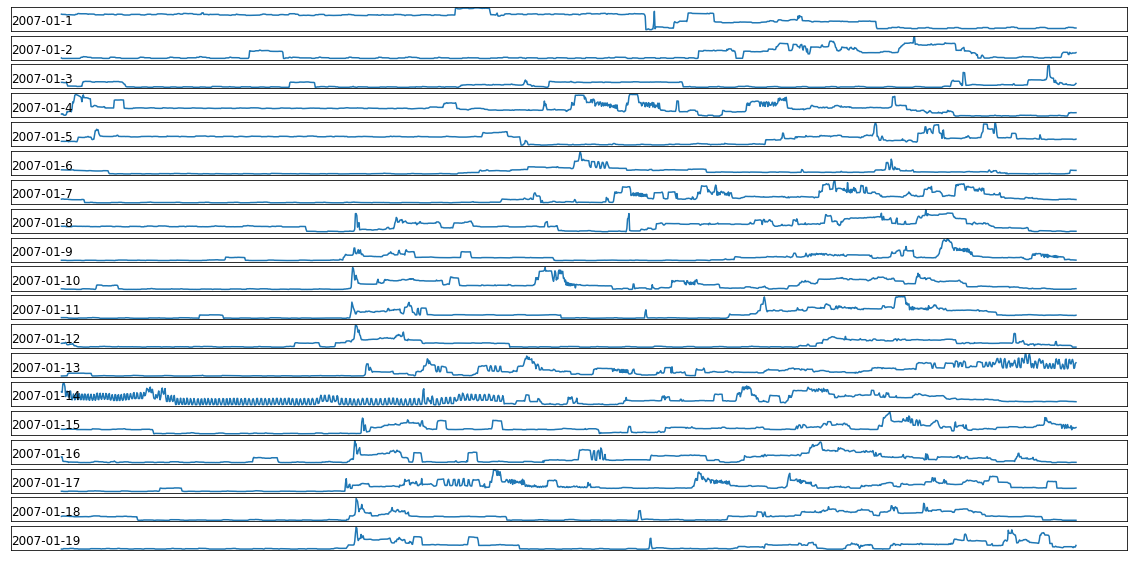

In [23]:
# daily line plots for power usage dataset
from pandas import read_csv
from matplotlib import pyplot
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# plot active power for each year
days = [x for x in range(1, 20)]
pyplot.figure()
for i in range(len(days)):
	# prepare subplot
	ax = pyplot.subplot(len(days), 1, i+1)
	# determine the day to plot
	day = '2007-01-' + str(days[i])
	# get all observations for the day
	result = dataset[day]
	# plot the active power for the day
	pyplot.plot(result['Global_active_power'])
	# add a title to the subplot
	pyplot.title(day, y=0, loc='left', size=12)
	# turn off ticks to remove clutter
	pyplot.yticks([])
	pyplot.xticks([])
pyplot.show()

Running the example creates a single image with 20 line plots, one for the first 20 days in January 2007. There is commonality across the days; for example, many days consumption starts early morning, around 6-7AM. Some days show a drop in consumption in the middle of the day, which might make sense if most occupants are out of the house. We do see some strong overnight consumption on some days, that in a northern hemisphere January may match up with a heating system being used. Time of year, specifically the season and the weather that it brings, will be an important factor in modeling this data, as would be expected.


## 16.5 Time Series Data Distributions

Another important area to consider is the distribution of the variables. For example, it may be interesting to know if the distributions of observations are Gaussian or some other distribution. We can investigate the distributions of the data by reviewing histograms. 

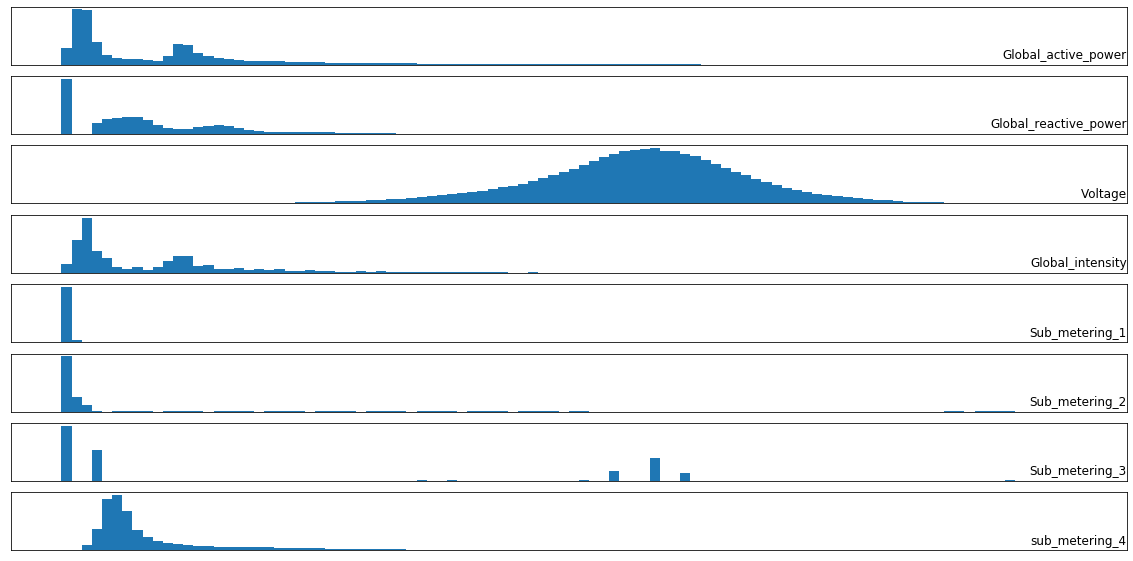

In [24]:
# histogram plots for power usage dataset
from pandas import read_csv
from matplotlib import pyplot
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# histogram plot for each variable
pyplot.figure()
for i in range(len(dataset.columns)):
	# create subplot
	pyplot.subplot(len(dataset.columns), 1, i+1)
	# get variable name
	name = dataset.columns[i]
	# create histogram
	dataset[name].hist(bins=100)
	# set title
	pyplot.title(name, y=0, loc='right')
	# turn off ticks to remove clutter
	pyplot.yticks([])
	pyplot.xticks([])
pyplot.show()

- We can see that active and reactive power, intensity, as well as the sub-metered power are all skewed distributions down towards small watt-hour or kilowatt values. We can also see that distribution of voltage data is strongly Gaussian.
- The distribution of active power appears to be bi-modal, meaning it looks like it has two mean groups of observations. We can investigate this further by looking at the distribution of active power consumption for the four full years of data. 

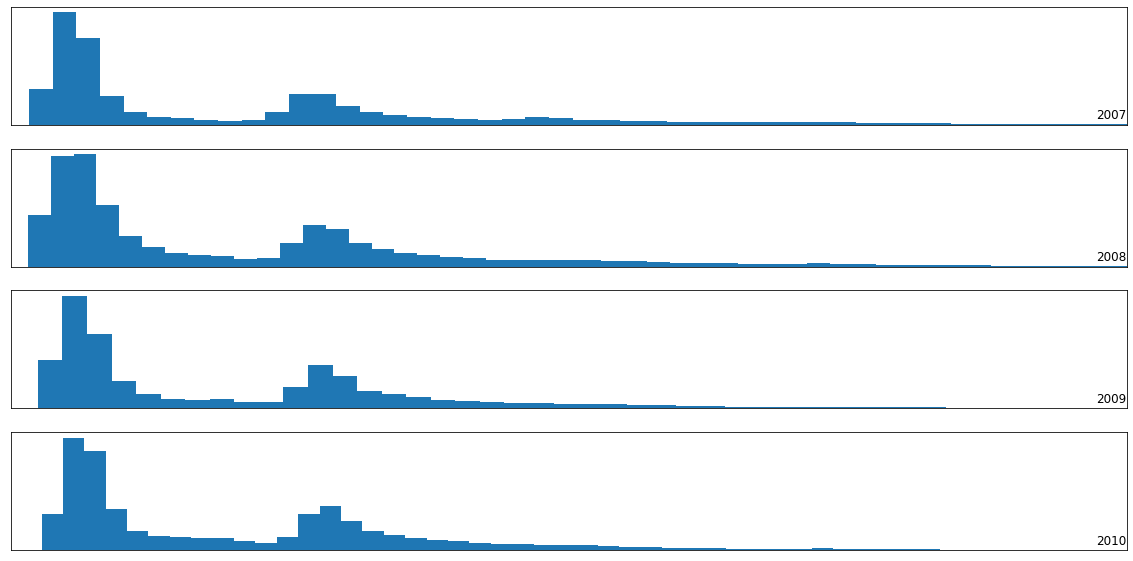

In [25]:
# yearly histogram plots for power usage dataset
from pandas import read_csv
from matplotlib import pyplot
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# plot active power for each year
years = ['2007', '2008', '2009', '2010']
pyplot.figure()
for i in range(len(years)):
	# prepare subplot
	ax = pyplot.subplot(len(years), 1, i+1)
	# determine the year to plot
	year = years[i]
	# get all observations for the year
	result = dataset[str(year)]
	# plot the active power for the year
	result['Global_active_power'].hist(bins=100)
	# zoom in on the distribution
	ax.set_xlim(0, 5)
	# add a title to the subplot
	pyplot.title(str(year), y=0, loc='right')
	# turn off ticks to remove clutter
	pyplot.yticks([])
	pyplot.xticks([])
pyplot.show()

Running the example creates a single plot with four figures, one for each of the years between 2007 to 2010. We can see that the distribution of active power consumption across those years looks very similar. The distribution is indeed bimodal with one peak around 0.3 KW and perhaps another around 1.3 KW. There is a long tail on the distribution to higher kilowatt values. It might open the door to notions of discretizing the data and separating it into peak 1, peak 2 or long tail. These groups or clusters for usage on a day or hour may be helpful in developing a predictive model.

It is possible that the identified groups may vary over the seasons of the year. We can investigate this by looking at the distribution for active power for each month in a year. 

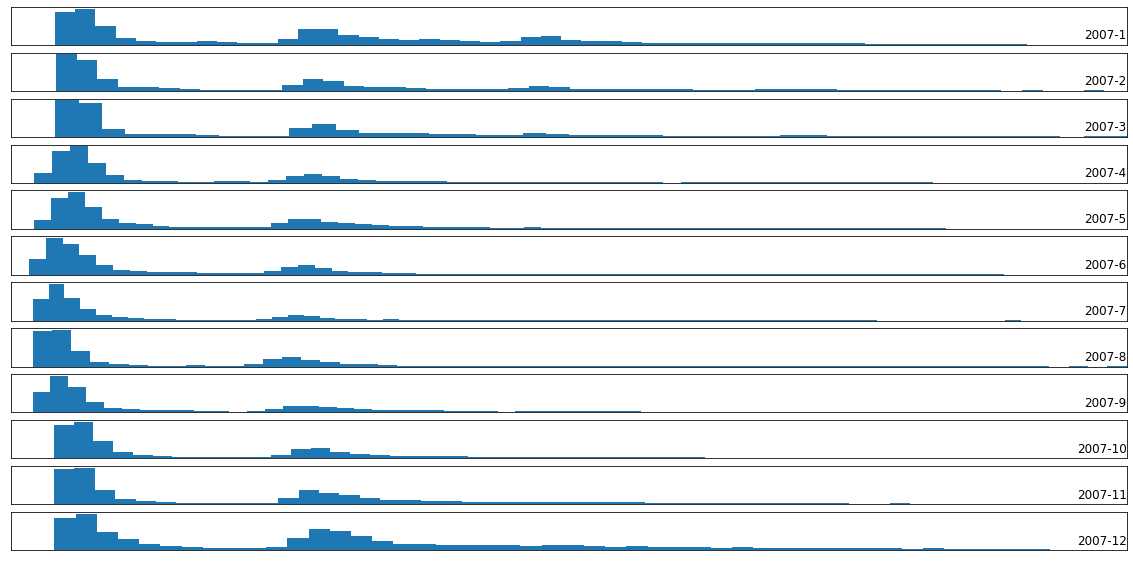

In [26]:
# monthly histogram plots for power usage dataset
from pandas import read_csv
from matplotlib import pyplot
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# plot active power for each year
months = [x for x in range(1, 13)]
pyplot.figure()
for i in range(len(months)):
	# prepare subplot
	ax = pyplot.subplot(len(months), 1, i+1)
	# determine the month to plot
	month = '2007-' + str(months[i])
	# get all observations for the month
	result = dataset[month]
	# plot the active power for the month
	result['Global_active_power'].hist(bins=100)
	# zoom in on the distribution
	ax.set_xlim(0, 5)
	# add a title to the subplot
	pyplot.title(month, y=0, loc='right')
	# turn off ticks to remove clutter
	pyplot.yticks([])
	pyplot.xticks([])
pyplot.show()

Running the example creates an image with 12 plots, one for each month in 2007. We can see generally the same data distribution each month. The axes for the plots appear to align (given the similar scales), and __we can see that the peaks are shifted down in the warmer northern hemisphere months and shifted up for the colder months__. We can also see a thicker or more prominent tail toward larger kilowatt values for the cooler months of December through to
March.

## 16.6 Ideas on Modeling

### 16.6.1 Problem Framing
Perhaps the most useful framing of the dataset is to forecast an interval of future active power consumption. Four examples include:
- Forecast hourly consumption for the next day.
- Forecast daily consumption for the next week.
- Forecast daily consumption for the next month.
- Forecast monthly consumption for the next year.

Generally, these types of forecasting problems are referred to as multi-step forecasting. Models that make use of all of the variables might be referred to as a multivariate multi-step forecasting models. 

### 16.6.2 Data Preparation

There is a lot of flexibility in preparing this data for modeling. The specific data preparation methods and their benefit really depend on the chosen framing of the problem and the modeling methods. Nevertheless, below is a list of general data preparation methods that may be useful:
- Daily differencing may be useful to adjust for the daily cycle in the data.
- Annual differencing may be useful to adjust for any yearly cycle in the data.
- Normalization may aid in reducing the variables with differing units to the same scale. 

There are many simple human factors that may be helpful in engineering features from the data, that in turn may make specific days easier to forecast. Some examples include:
- Indicating the time of day, to account for the likelihood of people being home or not.
- Indicating whether a day is a weekday or weekend.
- Indicating whether a day is a North American public holiday or not.

These factors may be significantly less important for forecasting monthly data, and perhaps to a degree for weekly data. More general features may include:
- Indicating the season, which may lead to the type or amount environmental control systems being used.

### 16.6.3 Modeling Methods
There are perhaps four classes of methods that might be interesting to explore on this problem; they are:
1. Naive Methods.
2. Classical Linear Methods. 
3. Machine Learning Methods. 
4. Deep Learning Methods.

### 16.6.4 Naive Methods
Naive methods would include methods that make very simple, but often very effective assumptions. Some examples include:
- Tomorrow will be the same as today.
- Tomorrow will be the same as this day last year. 􏰀 
- Tomorrow will be an average of the last few days.

#### Classical Linear Methods

Classical linear methods include techniques are very effective for univariate time series forecasting. Two important examples include:
- SARIMA.
- ETS (triple exponential smoothing).

#### Machine Learning Methods
Machine learning methods require that the problem be framed as a supervised learning problem. This would require that lag observations for a series be framed as input features, discarding the temporal relationship in the data. A suite of nonlinear and ensemble methods could be explored, including:
- k-Nearest Neighbors.
- Support Vector Machines.
- Decision Trees.
- Random Forest.
- Gradient Boosting Machines.

Careful attention is required to ensure that the fitting and evaluation of these models preserved the temporal structure in the data. This is important so that the method is not able to cheat by harnessing observations from the future. These methods are often agnostic to large numbers of variables and may aid in teasing out whether the additional variables can be harnessed and add value to predictive models.

#### Deep Learning Methods

combinations of these methods, such as CNN-LSTM and ConvLSTM, have proven effective on time series classification tasks. It is possible that these methods may be able to harness the large volume of minute-based data and multiple input variables.

## 16.8 Further Reading
This section provides more resources on the topic if you are looking to go deeper.

### 16.8.1 APIs
- pandas.read csv API. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
- matplotlib.pyplot API. https://matplotlib.org/api/pyplot_api.html


### 16.8.2 Articles
- Household Power Consumption Dataset, UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption
- AC power, Wikipedia. https://en.wikipedia.org/wiki/AC_power#Active,_reactive,_and_apparent_power

## 16.9 Summary
In this tutorial, you discovered a household power consumption dataset for multi-step time series forecasting and how to better understand the raw data using exploratory analysis. Specifically, you learned:
- The household power consumption dataset that describes electricity usage for a single house over four years.
- How to explore and understand the dataset using a suite of line plots for the series data and histogram for the data distributions.
- How to use the new understanding of the problem to consider different framings of the prediction problem, ways the data may be prepared, and modeling methods that may be used.
